In [15]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import cupy as cp

from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,roc_auc_score, f1_score,confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_eff
from tensorflow.keras.models import Model

import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_eff

import joblib

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/datasets/face_extraction'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import GPUtil

gpus = GPUtil.getGPUs()
for gpu in gpus:
    print(f"ID: {gpu.id}, Name: {gpu.name}")
    print(f"  Total Memory: {gpu.memoryTotal} MB")
    print(f"  Used Memory: {gpu.memoryUsed} MB")
    print(f"  Free Memory: {gpu.memoryFree} MB")
    print(f"  GPU Load: {gpu.load * 100:.1f}%")
    

Num GPUs Available:  1
ID: 0, Name: NVIDIA Tesla P100-SXM2-16GB
  Total Memory: 16280.0 MB
  Used Memory: 2.0 MB
  Free Memory: 16278.0 MB
  GPU Load: 0.0%


In [ ]:
# models
vgg_model = VGG16(weights='imagenet', include_top=False, pooling='avg')
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
eff_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

In [5]:
def extract_features_from_image(image_path):
    if not os.path.isfile(image_path):
        print(f"[ERRO] O arquivo {image_path} não é válido ou não é uma imagem.")
        return None

    img = cv2.imread(image_path)
    if img is None:
        print(f"[ERRO] Não foi possível carregar a imagem {image_path}.")
        return None

    try:
        # Redimensiona a imagem
        img_resized = cv2.resize(img, (224, 224))
        img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

        # --- Features de CNN ---
        img_batch_vgg = preprocess_vgg(np.expand_dims(img_rgb.astype('float32'), axis=0))
        img_batch_resnet = preprocess_resnet(np.expand_dims(img_rgb.astype('float32'), axis=0))
        img_batch_eff = preprocess_eff(np.expand_dims(img_rgb.astype('float32'), axis=0))

        vgg_feat = vgg_model.predict(img_batch_vgg, verbose=0).flatten()
        res_feat = resnet_model.predict(img_batch_resnet, verbose=0).flatten()
        eff_feat = eff_model.predict(img_batch_eff, verbose=0).flatten()

        # --- Média Azimutal do Espectro de Frequência ---
        azimuthal_feat = compute_azimuthal_average(img_resized)
        azimuthal_feat = azimuthal_feat[:100]  # padroniza tamanho

        # --- LBP com CuPy ---
        lbp_feat = local_binary_pattern(img_resized, P=8, R=1)

        # --- Combina todas as features ---
        combined = np.concatenate([vgg_feat, res_feat, eff_feat, azimuthal_feat, lbp_feat])
        return combined

    except Exception as e:
        print(f"[ERRO] Falha ao extrair características de {image_path}: {e}")
        return None

In [6]:
def compute_azimuthal_average(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    h, w = image.shape
    f = np.fft.fft2(image)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1e-10)

    center = (h // 2, w // 2)
    y, x = np.indices((h, w))
    r = np.sqrt((x - center[1])**2 + (y - center[0])**2).astype(int)

    tbin = np.bincount(r.ravel(), magnitude_spectrum.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = tbin / (nr + 1e-10)
    return radial_profile

In [7]:
def local_binary_pattern(image, P=8, R=1):
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    gray_gpu = cp.asarray(gray, dtype=cp.uint8)
    lbp_gpu = cp.zeros_like(gray_gpu)

    rows, cols = gray_gpu.shape
    angles = cp.linspace(0, 2 * cp.pi, P, endpoint=False)
    dx = R * cp.cos(angles)
    dy = -R * cp.sin(angles)

    for idx in range(P):
        fx = dx[idx]
        fy = dy[idx]

        x0 = cp.floor(fx).astype(cp.int32)
        x1 = x0 + 1
        y0 = cp.floor(fy).astype(cp.int32)
        y1 = y0 + 1

        x = cp.arange(R, rows - R)
        y = cp.arange(R, cols - R)
        X, Y = cp.meshgrid(x, y, indexing='ij')

        i0 = cp.clip(X + x0, 0, rows - 1)
        i1 = cp.clip(X + x1, 0, rows - 1)
        j0 = cp.clip(Y + y0, 0, cols - 1)
        j1 = cp.clip(Y + y1, 0, cols - 1)

        Ia = gray_gpu[i0, j0]
        Ib = gray_gpu[i0, j1]
        Ic = gray_gpu[i1, j0]
        Id = gray_gpu[i1, j1]

        wa = (1 - (fx - x0)) * (1 - (fy - y0))
        wb = (1 - (fx - x0)) * (fy - y0)
        wc = (fx - x0) * (1 - (fy - y0))
        wd = (fx - x0) * (fy - y0)

        interp = wa * Ia + wb * Ib + wc * Ic + wd * Id
        center = gray_gpu[X, Y]
        binary = (interp >= center).astype(cp.uint8)

        lbp_gpu[X, Y] += binary * (1 << idx)

    lbp_cpu = cp.asnumpy(lbp_gpu)
    hist, _ = np.histogram(lbp_cpu, bins=2**P, range=(0, 2**P))
    return hist / (hist.sum() + 1e-10)

In [11]:
def generate_model(real_path, fake_path, fake_name):
    X_train, y_train = [], []
    X_test, y_test = [], []

    for label, path in [("REAL", real_path), ("FAKE", fake_path)]:
        image_files = os.listdir(path)
        test_files = image_files[:50]
        train_files = image_files[50:]

        for image_name in tqdm(test_files, desc=f"{label} (TESTE)"):
            image_path = os.path.join(path, image_name)
            feat = extract_features_from_image(image_path)
            if feat is not None:
                X_test.append(feat)
                y_test.append(0 if label == "REAL" else 1)

        for image_name in tqdm(train_files, desc=f"{label} (TREINO)"):
            image_path = os.path.join(path, image_name)
            feat = extract_features_from_image(image_path)
            if feat is not None:
                X_train.append(feat)
                y_train.append(0 if label == "REAL" else 1)

    if len(X_train) == 0 or len(X_test) == 0:
        print("Erro: Não foram extraídas características suficientes.")
        return

    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    # PCA com 95% de variância
    pca = PCA(n_components=0.95)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    print(f"[INFO] PCA - Componentes mantidos: {pca.n_components_} para {fake_name}")

    # Classificador
    svm = SVC(kernel='linear', probability=True)
    svm.fit(X_train_pca, y_train)
    y_pred = svm.predict(X_test_pca)

    # Métricas
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')

    try:
        y_scores = svm.decision_function(X_test_pca)
        auc = roc_auc_score(y_test, y_scores)
    except:
        auc = None

    report = classification_report(y_test, y_pred)
    print(f"\n=== Avaliação para FAKE = {fake_name} ===")
    print("Accuracy:", acc)
    print("F1-score (macro):", f1)
    if auc:
        print("AUC:", auc)
    print("Classification Report:\n", report)

    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])
    disp.plot()
    plt.title(f"Matriz de Confusão - {fake_name}")
    plt.show()

    # Criar diretórios de saída
    os.makedirs("modelos", exist_ok=True)
    os.makedirs("logs", exist_ok=True)

    # Salvar modelos
    joblib.dump(svm, f"modelos/svm_{fake_name}.joblib")
    joblib.dump(pca, f"modelos/pca_{fake_name}.joblib")

    # Salvar log de avaliação
    log_path = f"logs/avaliacao_{fake_name}.txt"
    with open(log_path, "w") as f:
        f.write(f"FAKE technique: {fake_name}\n")
        f.write(f"PCA components retained: {pca.n_components_}\n")
        f.write(f"Accuracy: {acc:.4f}\n")
        f.write(f"F1-score (macro): {f1:.4f}\n")
        if auc is not None:
            f.write(f"AUC: {auc:.4f}\n")
        else:
            f.write("AUC: N/A (decision_function not available)\n")
        f.write("\nClassification Report:\n")
        f.write(report)
    print(f"[INFO] Resultados salvos em {log_path}")

In [8]:
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["REAL", "FAKE"])
    plt.figure(figsize=(5, 5))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

In [9]:
def train_all_models():
    real_path = "datasets/face_extraction/REAL/"
    fake_paths = {
        "Deepfake": "datasets/face_extraction/Deepfake/",
        "DeepfakeDetection": "datasets/face_extraction/DeepfakeDetection/",
        "Face2Face": "datasets/face_extraction/Face2Face/",
        "FaceShifter": "datasets/face_extraction/FaceShifter/",
        "FaceSwap": "datasets/face_extraction/FaceSwap/",
        "NeuralTextures": "datasets/face_extraction/NeuralTextures/"
    }

    for fake_name, fake_path in fake_paths.items():
        generate_model(real_path, fake_path, fake_name)

FAKE (TREINO): 100%|██████████| 200/200 [00:28<00:00,  7.10it/s]


[INFO] PCA - Componentes mantidos: 36 para Deepfake

=== Avaliação para FAKE = Deepfake ===
Accuracy: 0.7
F1-score (macro): 0.6940024479804162
AUC: 0.756
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.56      0.65        50
           1       0.66      0.84      0.74        50

    accuracy                           0.70       100
   macro avg       0.72      0.70      0.69       100
weighted avg       0.72      0.70      0.69       100



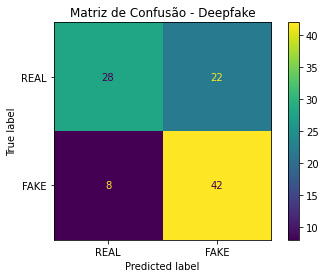

[INFO] Resultados salvos em logs/avaliacao_Deepfake.txt


FAKE (TREINO): 100%|██████████| 200/200 [00:28<00:00,  7.05it/s]


[INFO] PCA - Componentes mantidos: 38 para DeepfakeDetection

=== Avaliação para FAKE = DeepfakeDetection ===
Accuracy: 0.99
F1-score (macro): 0.98999899989999
AUC: 0.9995999999999999
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      0.98      0.99        50

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



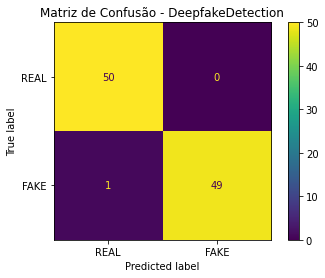

[INFO] Resultados salvos em logs/avaliacao_DeepfakeDetection.txt


FAKE (TREINO): 100%|██████████| 200/200 [00:28<00:00,  6.97it/s]


[INFO] PCA - Componentes mantidos: 26 para Face2Face

=== Avaliação para FAKE = Face2Face ===
Accuracy: 0.52
F1-score (macro): 0.5169082125603865
AUC: 0.5404
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.44      0.48        50
           1       0.52      0.60      0.56        50

    accuracy                           0.52       100
   macro avg       0.52      0.52      0.52       100
weighted avg       0.52      0.52      0.52       100



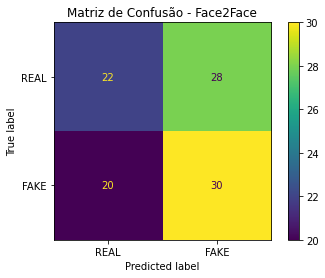

[INFO] Resultados salvos em logs/avaliacao_Face2Face.txt


FAKE (TREINO): 100%|██████████| 200/200 [00:28<00:00,  7.00it/s]


[INFO] PCA - Componentes mantidos: 28 para FaceShifter

=== Avaliação para FAKE = FaceShifter ===
Accuracy: 0.62
F1-score (macro): 0.6175523349436394
AUC: 0.7048
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.54      0.59        50
           1       0.60      0.70      0.65        50

    accuracy                           0.62       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.62      0.62      0.62       100



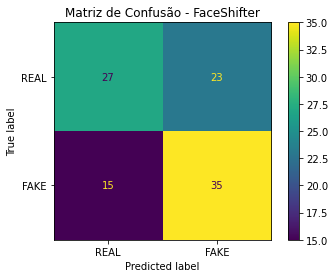

[INFO] Resultados salvos em logs/avaliacao_FaceShifter.txt


FAKE (TREINO): 100%|██████████| 200/200 [00:28<00:00,  6.92it/s]


[INFO] PCA - Componentes mantidos: 33 para FaceSwap

=== Avaliação para FAKE = FaceSwap ===
Accuracy: 0.66
F1-score (macro): 0.66
AUC: 0.7172000000000001
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.66      0.66        50
           1       0.66      0.66      0.66        50

    accuracy                           0.66       100
   macro avg       0.66      0.66      0.66       100
weighted avg       0.66      0.66      0.66       100



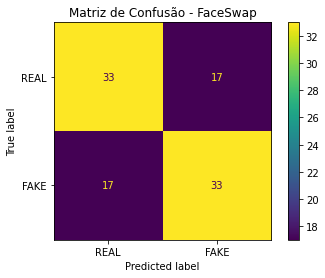

[INFO] Resultados salvos em logs/avaliacao_FaceSwap.txt


FAKE (TREINO): 100%|██████████| 200/200 [00:29<00:00,  6.88it/s]


[INFO] PCA - Componentes mantidos: 27 para NeuralTextures

=== Avaliação para FAKE = NeuralTextures ===
Accuracy: 0.55
F1-score (macro): 0.5331465919701215
AUC: 0.5720000000000001
Classification Report:
               precision    recall  f1-score   support

           0       0.58      0.36      0.44        50
           1       0.54      0.74      0.62        50

    accuracy                           0.55       100
   macro avg       0.56      0.55      0.53       100
weighted avg       0.56      0.55      0.53       100



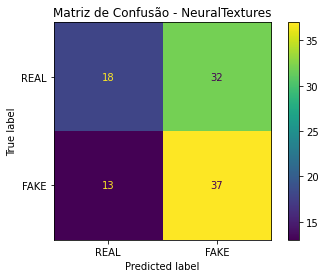

[INFO] Resultados salvos em logs/avaliacao_NeuralTextures.txt


In [16]:
# Execução
train_all_models()